In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# Carregando dados

In [2]:
# Carregar os dados
df = pd.read_csv('data_yfinance/fiis.csv')

# Filtrar as datas de interesse (2017-02-24 até hoje)
start_date = '2019-01-01'
df['Date'] = pd.to_datetime(df['Date'])
filtered_df = df[df['Date'] >= start_date]

# Removendo ".SA"

In [3]:
filtered_df['ticker'] = filtered_df['ticker'].apply(lambda x: x[:-3])
filtered_df

C:\Users\Matheus Poletto\AppData\Local\Temp\ipykernel_17540\2309112757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ticker'] = filtered_df['ticker'].apply(lambda x: x[:-3])


,Date,Open,High,Low,Close,ticker
0,2022-12-21,10.000000,10.050000,10.000000,10.030000,AAZQ11
1,2022-12-22,10.200000,10.200000,9.500000,10.000000,AAZQ11
2,2022-12-23,10.000000,10.000000,9.800000,10.000000,AAZQ11
3,2022-12-26,10.090000,10.090000,9.850000,9.980000,AAZQ11
4,2022-12-27,9.980000,9.980000,9.400000,9.700000,AAZQ11
...,...,...,...,...,...,...
319361,2024-07-03,698.000000,698.000000,698.000000,698.000000,ZIFI11
319362,2024-07-04,633.059998,689.979980,633.059998,689.979980,ZIFI11
319363,2024-07-05,714.960022,714.960022,714.960022,714.960022,ZIFI11
319364,2024-07-08,680.010010,697.989990,660.000000,660.000000,ZIFI11


# Cálculo estatísticas

In [4]:
# Calcular as estatísticas relevantes
def calculate_ticker_stats(df):
    # Calcular retornos diários
    df['Return'] = df.groupby('ticker')['Close'].pct_change()

    # Definindo uma taxa livre de risco anual
    annual_risk_free_rate = 0.0729  # 7,29% foi a média anual aproximada de 100% do CDI nos últimos 7 anos

    # Calcular o número de anos nos dados para anualizar os retornos diários
    num_years = (df['Date'].max() - df['Date'].min()).days / 365.25

    # Agrupando por 'ticker' e calculando as métricas necessárias
    ticker_stats = df.groupby('ticker').agg(
        avg_return=('Return', lambda x: (1 + x).prod() ** (1 / num_years) - 1),  # retorno médio anualizado
        volatility=('Return', 'std'),  # desvio padrão dos retornos
        cumulative_return=('Return', lambda x: (1 + x).prod() - 1),  # retorno acumulado
        sharpe_ratio=('Return', lambda x: ((x.mean() * 252 - annual_risk_free_rate) /
                                           (x.std() * (252 ** 0.5))) if x.std() != 0 else None)
        # Sharpe ratio anualizado, considerando 252 dias de negociação por ano
    ).reset_index()

    return ticker_stats

In [5]:
def calculate_rvi(avg_return, volatility, sharpe_ratio, alpha, beta, gamma):
    return alpha * avg_return + beta * volatility + gamma * sharpe_ratio


# Pesos para o modelo de decisão
weights = {
    'Conservador': {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.1},
    'Moderado': {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.8},
    'Arrojado': {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.1}
}

def apply_profiles(ticker_stats, weights):
    rvi_scores = {}
    for profile, params in weights.items():
        rvi_scores[profile] = ticker_stats.apply(
            lambda row: calculate_rvi(row['avg_return'], row['volatility'], row['sharpe_ratio'], 
                                      params['alpha'], params['beta'], params['gamma']),
            axis=1
        )
    return rvi_scores

# Calcular as estatísticas dos tickers
ticker_stats = calculate_ticker_stats(filtered_df)

# Aplicar os perfis de investimento
rvi_scores = apply_profiles(ticker_stats, weights)

# Adicionar os scores ao dataframe de estatísticas dos tickers
for profile, score in rvi_scores.items():
    ticker_stats[f'rvi_{profile}'] = score

C:\Users\Matheus Poletto\AppData\Local\Temp\ipykernel_17540\2540944230.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'] = df.groupby('ticker')['Close'].pct_change()


# Resultado

## Resultado ordenado por avg_return

In [6]:
df = ticker_stats.sort_values(by='avg_return', ascending=False)
df

,ticker,avg_return,volatility,cumulative_return,sharpe_ratio,rvi_Conservador,rvi_Moderado,rvi_Arrojado
54,BVAR11,3.926953,244.453986,6618.047826,1.382283,196.094112,25.943920,27.725189
290,SHPH11,0.108888,0.028924,0.768623,0.243071,0.058335,0.208238,0.114310
105,FLRP11,0.099727,0.022209,0.689502,0.281785,0.055919,0.237621,0.110181
317,VERE11,0.099690,0.021450,0.689189,0.232449,0.050374,0.198073,0.105142
138,HGPO11,0.099516,0.011222,0.687718,0.263901,0.045319,0.222194,0.107125
...,...,...,...,...,...,...,...,...
102,FISC11,-0.384405,0.034935,-0.931200,-0.419900,-0.052482,-0.370867,-0.346021
273,RNDP11,-0.384992,0.031469,-0.931561,-0.873932,-0.100717,-0.734498,-0.392240
97,FCFL11,-0.407056,0.029061,-0.944054,-0.444878,-0.061945,-0.393702,-0.367226
187,KNRE11,-0.430803,0.034582,-0.955348,-0.889773,-0.104392,-0.751440,-0.430161


## Resultado com aplicação de coloração

In [7]:
df_rvi = pd.DataFrame(ticker_stats)

# Função para aplicar coloração condicional
def color_negative_red(value):
    color = 'red' if value < 0 else 'black'
    return f'color: {color}'

# Aplicar coloração condicional a todas as colunas exceto 'ticker' e 'volatility'
styled_df = df_rvi.style.applymap(color_negative_red, subset=pd.IndexSlice[:, ['avg_return', 'cumulative_return', 'sharpe_ratio', 'rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']])

# Aplicar um gradiente de cor para a coluna 'volatility'
styled_df = styled_df.background_gradient(subset=['volatility'], cmap='Reds')

# Aplicar gradiente verde para valores positivos
def background_gradient(s, m, M, cmap='Greens', low=0, high=0):
    rng = M - m
    norm = mcolors.Normalize(m - (rng * low), M + (rng * high))
    normed = norm(s.values)
    c = [plt.get_cmap(cmap)(x) for x in normed]
    return ['background-color: %s' % mcolors.rgb2hex(rgb[:3]) for rgb in c]

# Aplicar gradiente verde às colunas especificadas
columns_to_gradient = ['avg_return', 'cumulative_return', 'sharpe_ratio', 'rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']
for column in columns_to_gradient:
    styled_df = styled_df.apply(background_gradient, subset=[column], cmap='Greens', m=df_rvi[column].min(), M=df_rvi[column].max())

# Mostrar a tabela estilizada
styled_df

C:\Users\Matheus Poletto\AppData\Local\Temp\ipykernel_17540\3579681204.py:9: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df_rvi.style.applymap(color_negative_red, subset=pd.IndexSlice[:, ['avg_return', 'cumulative_return', 'sharpe_ratio', 'rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']])


,ticker,avg_return,volatility,cumulative_return,sharpe_ratio,rvi_Conservador,rvi_Moderado,rvi_Arrojado
0,AAZQ11,-0.053863,0.010647,-0.263210,-1.529003,-0.149769,-1.227524,-0.194926
1,ABCP11,-0.045753,0.013127,-0.227689,-0.472483,-0.041322,-0.381249,-0.082538
2,AFHI11,0.001726,0.007681,0.009558,-0.512728,-0.044955,-0.409242,-0.049124
3,AIEC11,-0.063133,0.010133,-0.302164,-1.345690,-0.132776,-1.081852,-0.184062
4,AJFI11,-0.033634,0.008231,-0.172000,-2.711530,-0.267932,-2.171765,-0.297237
5,ALMI11,-0.129796,0.022960,-0.535587,-0.737666,-0.068378,-0.600817,-0.175307
6,ALZC11,-0.005506,0.006599,-0.030000,-1.907566,-0.186028,-1.525944,-0.194501
7,ALZM11,-0.041372,0.032837,-0.207921,0.033018,0.025434,0.025561,-0.026512
8,ALZR11,0.026056,0.010702,0.152464,-0.190654,-0.007898,-0.148848,0.002849
9,ANCR11,0.065353,0.015809,0.418000,0.088329,0.028016,0.078779,0.062696


# Exportação dos dados

In [9]:
if not os.path.exists('data_yfinance'):
    os.makedirs('data_yfinance')
    
df.to_csv("data_yfinance\\fiis_rvi.csv", index=False)

# Criação de visuais

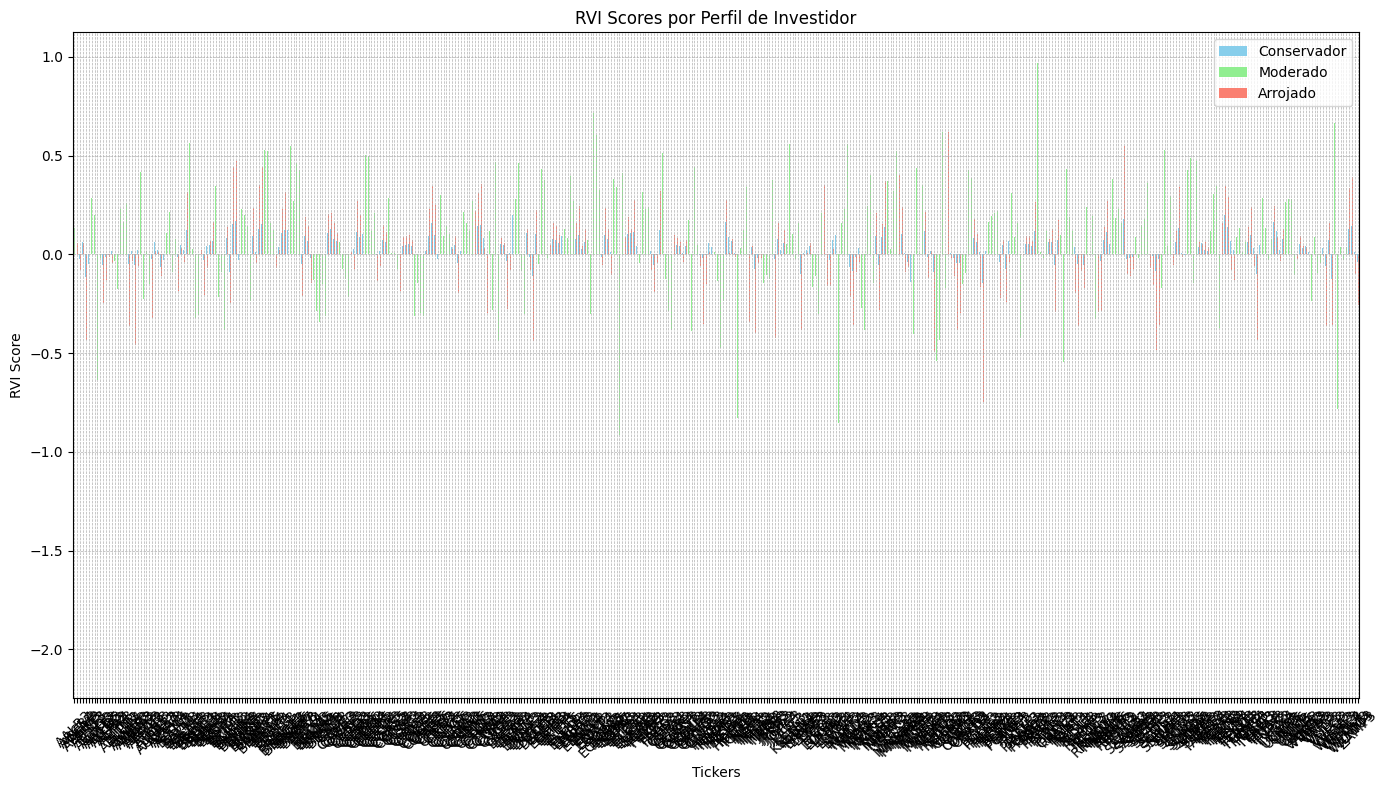

In [16]:
# Função para plotar um gráfico de barras colorido com grid
def plot_colorful_bars_with_grid(ticker_stats):
    profiles = ['rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']
    colors = ['skyblue', 'lightgreen', 'salmon']
    ticker_stats.set_index('ticker')[profiles].plot(kind='bar', color=colors, figsize=(14, 8))
    plt.title('RVI Scores por Perfil de Investidor')
    plt.xlabel('Tickers')
    plt.ylabel('RVI Score')
    plt.legend(['Conservador', 'Moderado', 'Arrojado'])
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Plotar o gráfico colorido com grid
plot_colorful_bars_with_grid(ticker_stats)

In [17]:
# Visualizar as 5 primeiras ações únicas no dataframe
top_tickers = df['ticker'].unique()[:5]

# Filtrar o dataframe para incluir apenas as 5 ações
filtered_df = df[df['ticker'].isin(top_tickers)]

# Normalizar os preços de fechamento para cada ação
normalized_df = filtered_df.copy()
for ticker in top_tickers:
    initial_value = normalized_df[normalized_df['ticker'] == ticker]['Close'].iloc[0]
    normalized_df.loc[normalized_df['ticker'] == ticker, 'Normalized_Close'] = 100 * (normalized_df[normalized_df['ticker'] == ticker]['Close'] / initial_value - 1)

# Plotar as séries temporais normalizadas para cada ticker
plt.figure(figsize=(14, 8))
for ticker in top_tickers:
    plt.plot(normalized_df[normalized_df['ticker'] == ticker]['Date'], normalized_df[normalized_df['ticker'] == ticker]['Normalized_Close'], label=ticker)

plt.title('Preço de Fechamento Normalizado das Ações - Série Temporal (Porcentagem)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento Normalizado (%)')
plt.legend(title='Ações')
plt.grid(True)
plt.show()

KeyError: 'Close'